In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ismailpromus_skin_diseases_image_dataset_path = kagglehub.dataset_download('ismailpromus/skin-diseases-image-dataset')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0067726.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0026846.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0059972.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0028020.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0055027.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0030459.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0069291.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/6. Benign Keratosis-like Lesions (BKL) 2624/ISIC_0071502.jpg
/kaggle/input/skin-diseases-i

# Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Keras imports
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import EfficientNetB7
from keras.callbacks import ReduceLROnPlateau
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Updated ImageDataGenerator import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Sklearn imports
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# General imports
import random
import keras

import shutil

# Copy the data to working directory

In [ ]:
# Define paths
data_path = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES'
output_path = '/kaggle/working/Skin-disease-images'


# Remove the existing dataset from the working directory if it exists
if os.path.exists(output_path):
    shutil.rmtree(output_path)

# Copy the dataset to a writable directory
if not os.path.exists(output_path):
    shutil.copytree(data_path, output_path)

# Checking Class distribution

Class counts: [2079, 1702, 3140, 1257, 7970, 1677, 2103, 2055, 1847, 3323]


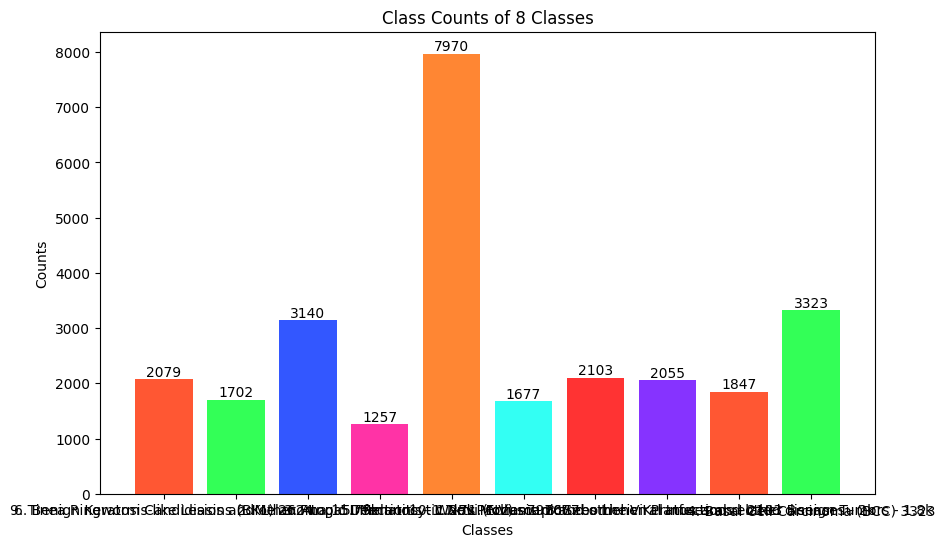

In [ ]:
# Use the copied dataset
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6',
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

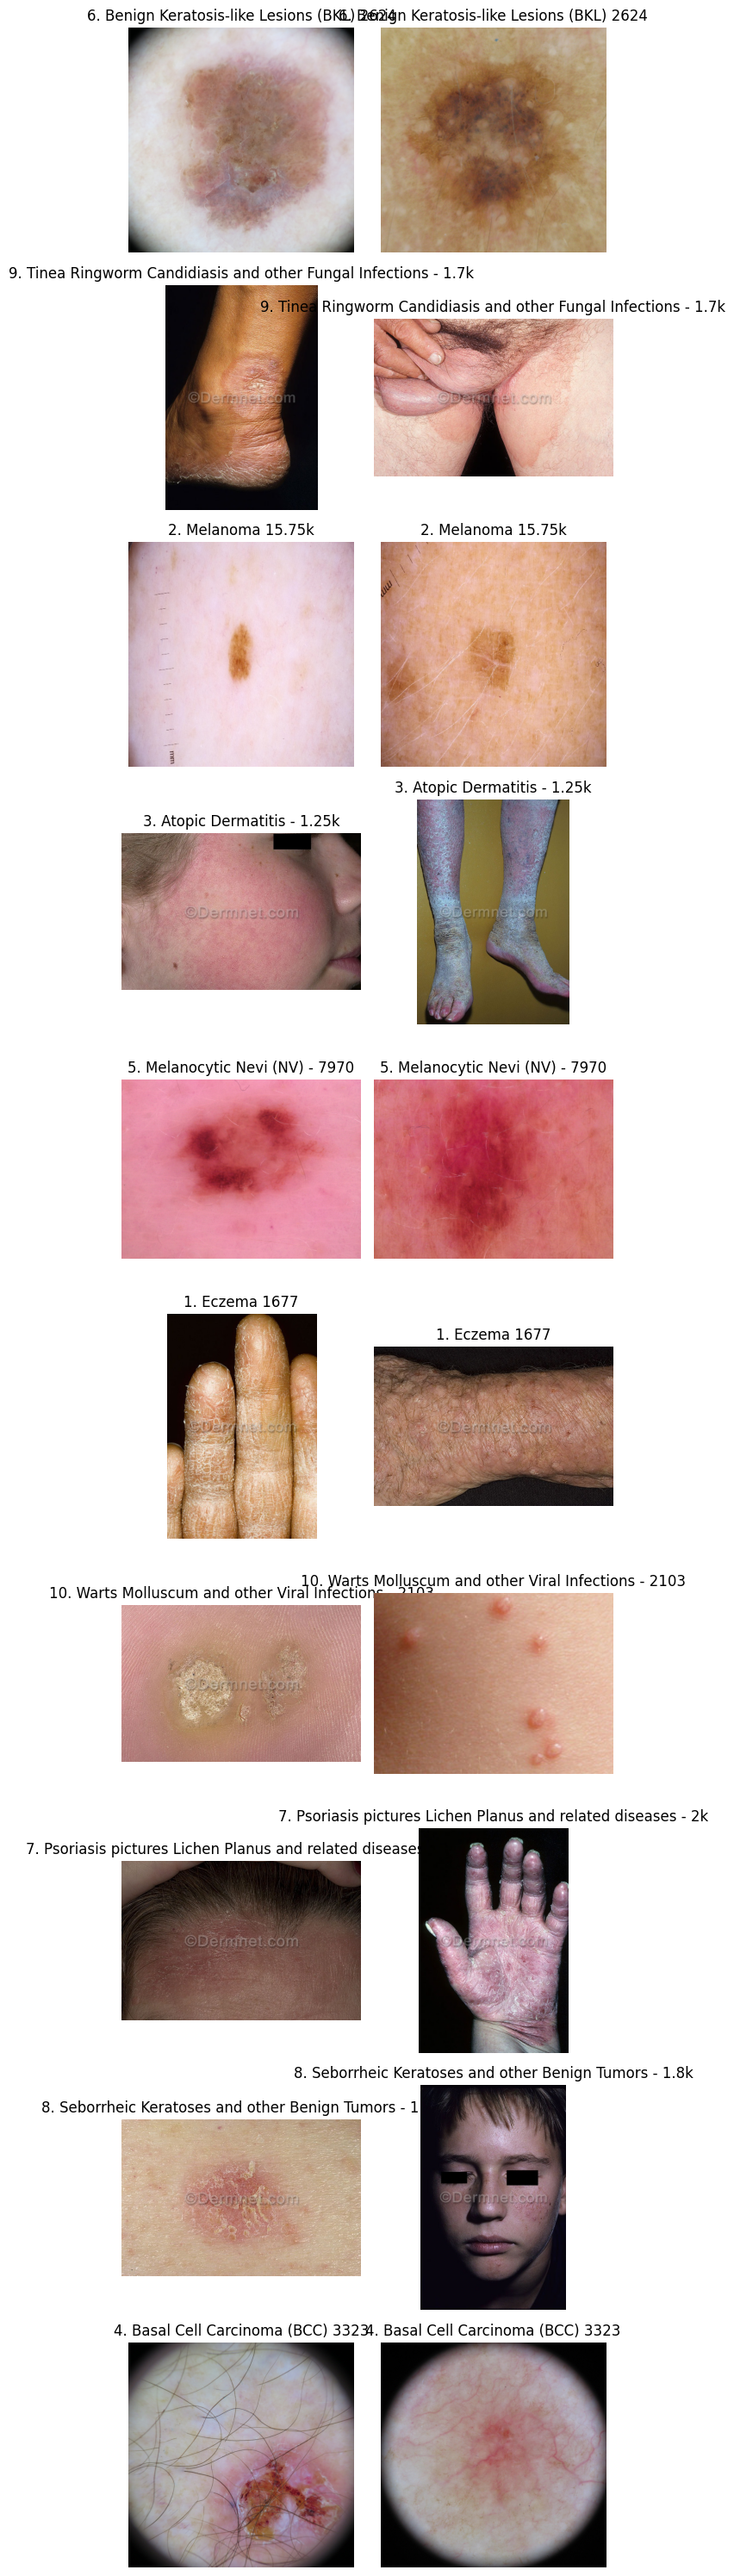

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Show 2 images from each class
num_images_per_class = 2
fig, axes = plt.subplots(len(classes), num_images_per_class, figsize=(num_images_per_class * 3 ,len(classes) * 3))

for i, class_name in enumerate(classes):
    class_dir = os.path.join(output_path, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_images = random.sample(image_files, min(num_images_per_class, len(image_files)))

    for j in range(num_images_per_class):
        ax = axes[i, j] if len(classes) > 1 else axes[j]  # handle 1-class case
        if j < len(sample_images):
            img_path = os.path.join(class_dir, sample_images[j])
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(f"{class_name}")
        ax.axis('off')

plt.tight_layout()
plt.show()


# Oversampling and Undersampling

In [ ]:
from PIL import Image
import numpy as np

# Oversampler function
def oversampler(class_name, class_count, target=7000, batch_size=32, target_size=(240, 240)):
    # Initialize the ImageDataGenerator with augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = os.path.join(output_path, class_name)
    save_dir = curr_dir

    # Load images from the current class folder
    images = os.listdir(curr_dir)
    images = [os.path.join(curr_dir, img) for img in images]

    cnt = class_count
    target = target

    # Loop over images in batches, apply augmentation, and save them
    while cnt < target:
        batch_images = []

        # Load and resize images to the target size before converting to NumPy array
        for img_path in random.sample(images, batch_size):
            img = Image.open(img_path)
            img = img.resize(target_size)  # Resize the image
            img = np.array(img)  # Convert the PIL image to a NumPy array
            batch_images.append(img)

        batch_images = np.array(batch_images)  # Convert the list of images to a NumPy array

        # Process and augment the batch of images
        for _ in datagen.flow(batch_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            cnt += batch_size
            if cnt >= target:
                break

        print(f"Processed {cnt}/{target} images for {class_name}")

# Undersampler function
def undersampler(class_name, class_count, target_count=7000):
    curr_dir = os.path.join(output_path, class_name)
    images = os.listdir(curr_dir)

    # Calculate the number of images to delete
    images_to_delete = random.sample(images, class_count - target_count)

    # Delete images in batches
    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

    print(f"Deleted {len(images_to_delete)} images for {class_name}")

In [ ]:
# Oversample or undersample each class
for i, class_name in enumerate(classes):
    if class_counts[i] < 7000:
        oversampler(class_name, class_counts[i])
    else:
        undersampler(class_name, class_counts[i])

print("Oversampling and undersampling completed successfully.")

Processed 7007/7000 images for 6. Benign Keratosis-like Lesions (BKL) 2624
Processed 7014/7000 images for 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k
Processed 7012/7000 images for 2. Melanoma 15.75k
Processed 7017/7000 images for 3. Atopic Dermatitis - 1.25k
Deleted 970 images for 5. Melanocytic Nevi (NV) - 7970
Processed 7021/7000 images for 1. Eczema 1677
Processed 7031/7000 images for 10. Warts Molluscum and other Viral Infections - 2103
Processed 7015/7000 images for 7. Psoriasis pictures Lichen Planus and related diseases - 2k
Processed 7031/7000 images for 8. Seborrheic Keratoses and other Benign Tumors - 1.8k
Processed 7003/7000 images for 4. Basal Cell Carcinoma (BCC) 3323
Oversampling and undersampling completed successfully.


# Checking class imbalance

Class counts: [6969, 6979, 6988, 6970, 7000, 6978, 6986, 6978, 6993, 6977]


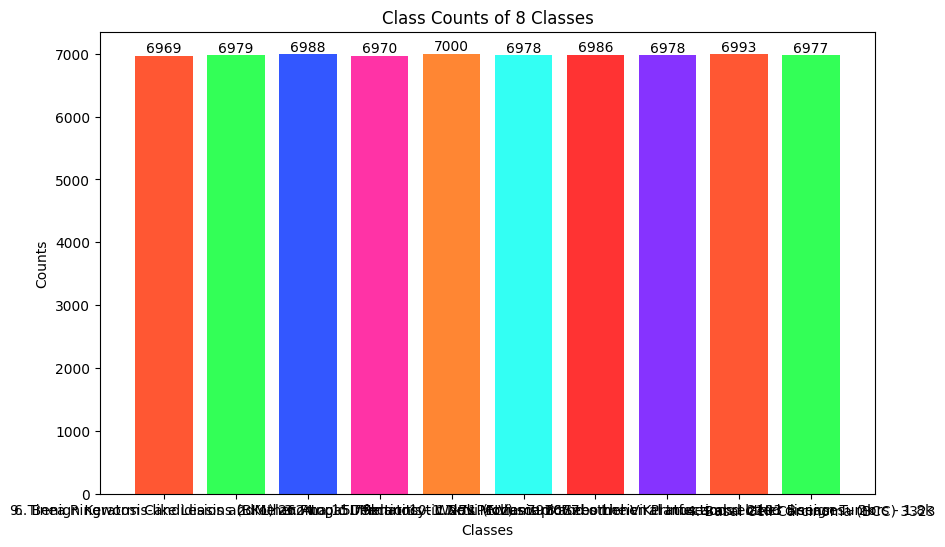

In [ ]:
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6',
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 8 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

# Train and Test Split

In [ ]:
import os
import random
import shutil

# Define paths for training, validation, and testing datasets
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

# Create directories for each dataset split
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the split ratios for train, validation, and test datasets
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Loop over each class in the output dataset and split it
for class_folder in os.listdir(output_path):  # using the output_path where dataset resides
    class_path = os.path.join(output_path, class_folder)

    # Create class directories in train, val, and test folders
    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)

    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)

    # List and shuffle the images in the current class folder
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)

    # Split the images based on the defined ratios
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val

    # Allocate images to each split
    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]

    # Copy images to the appropriate directories
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))

    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))

    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Dataset split completed successfully.")

Dataset split completed successfully.


# Loading Images

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define image size and batch size
img_size = (256, 256)
batch_size = 32

# Paths to train and validation datasets (as defined in the previous steps)
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

# Create the train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)

# Get the class names from the training dataset
class_names = train_dataset.class_names

# Create the validation dataset
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)


Found 48869 files belonging to 10 classes.
Found 10467 files belonging to 10 classes.


# Preprocessing the data

In [ ]:
import tensorflow as tf
# Preprocessing function
@tf.function
def preprocess_image(image, label):
    # Resize the image
    image = tf.image.resize(image, [256, 256])
    # Apply EfficientNet preprocessing
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Apply the preprocessing pipeline to the datasets
train_dataset = train_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

# Model Building

In [ ]:
from keras.applications.efficientnet import preprocess_input


# Feature extractor
base_model = keras.applications.EfficientNetB3(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

for layer in base_model.layers:
    layer.trainable = False

# Build model
inputs = base_model.input
x = BatchNormalization()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x) #output layer
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


# Train the model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define learning rate reduction callback
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model without EarlyStopping
epochs = 25
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[lr_reduction]
)

# Final training and validation results
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

print(f"\nTraining Accuracy: {train_acc:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


Epoch 1/25
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 171s 112ms/step - accuracy: 0.9524 - loss: 0.1347 - val_accuracy: 0.9096 - val_loss: 0.3016 - learning_rate: 4.0000e-05
Epoch 2/25
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 219s 123ms/step - accuracy: 0.9510 - loss: 0.1374 - val_accuracy: 0.9095 - val_loss: 0.3032 - learning_rate: 4.0000e-05
Epoch 3/25
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 177s 116ms/step - accuracy: 0.9558 - loss: 0.1271 - val_accuracy: 0.9108 - val_loss: 0.3095 - learning_rate: 4.0000e-05
Epoch 4/25
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 177s 116ms/step - accuracy: 0.9550 - loss: 0.1238 - val_accuracy: 0.9105 - val_loss: 0.3113 - learning_rate: 4.0000e-05
Epoch 5/25
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 211s 122ms/step - accuracy: 0.9588 - loss: 0.1176 - val_accuracy: 0.9110 - val_loss: 0.3103 - learning_rate: 8.0000e-06
Epoch 6/25
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 192s 116ms/step - accuracy: 0.9566 - loss: 0.1207 - val_accuracy: 0.9112 - val_loss: 0.3101 - learning_rate: 8.0000e-06
Epoch 7/25
1527/1527 ━━━━━━━

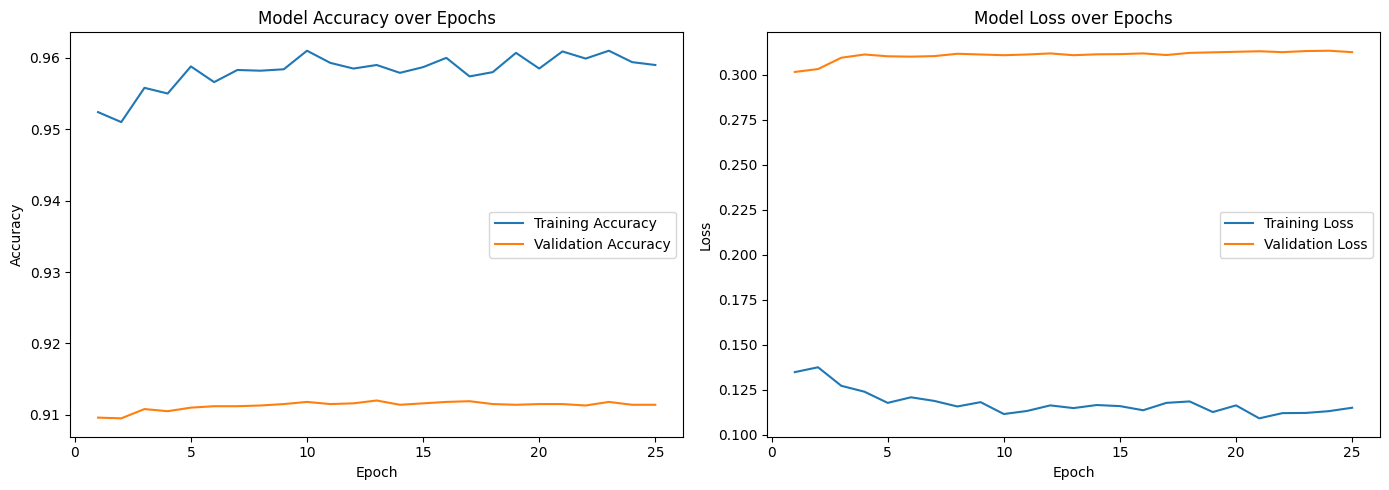

In [ ]:
import matplotlib.pyplot as plt

# Manually extracted values from your logs (25 epochs)
accuracy = [0.9524, 0.9510, 0.9558, 0.9550, 0.9588, 0.9566, 0.9583, 0.9582, 0.9584, 0.9610,
            0.9593, 0.9585, 0.9590, 0.9579, 0.9587, 0.9600, 0.9574, 0.9580, 0.9607, 0.9585,
            0.9609, 0.9599, 0.9610, 0.9594, 0.9590]

val_accuracy = [0.9096, 0.9095, 0.9108, 0.9105, 0.9110, 0.9112, 0.9112, 0.9113, 0.9115, 0.9118,
                0.9115, 0.9116, 0.9120, 0.9114, 0.9116, 0.9118, 0.9119, 0.9115, 0.9114, 0.9115,
                0.9115, 0.9113, 0.9118, 0.9114, 0.9114]

loss = [0.1347, 0.1374, 0.1271, 0.1238, 0.1176, 0.1207, 0.1187, 0.1156, 0.1180, 0.1114,
        0.1131, 0.1162, 0.1147, 0.1164, 0.1158, 0.1135, 0.1176, 0.1184, 0.1125, 0.1162,
        0.1090, 0.1119, 0.1120, 0.1130, 0.1149]

val_loss = [0.3016, 0.3032, 0.3095, 0.3113, 0.3103, 0.3101, 0.3104, 0.3117, 0.3113, 0.3109,
            0.3113, 0.3119, 0.3109, 0.3114, 0.3115, 0.3119, 0.3110, 0.3122, 0.3125, 0.3128,
            0.3131, 0.3126, 0.3132, 0.3134, 0.3126]

epochs = list(range(1, 26))

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Saving the model

In [ ]:
# Save the model after training
model_save_path = '/kaggle/working/my_model.h5'
model.save(model_save_path)

# Optionally, display a message confirming the model is saved
print(f'Model saved at {model_save_path}')

Model saved at /kaggle/working/my_model.h5
